In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold)
from sklearn.preprocessing import (PolynomialFeatures, LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer, OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, classification_report)

In [2]:
train_df = pd.read_csv("train_transformed_cleaned.csv")
test_df = pd.read_csv("test_transformed_cleaned.csv")
df_merged = pd.read_csv("df_merged.csv")

In [3]:
# Split the dataset
train_df, test_df = train_test_split(df_merged, test_size=0.2, random_state=42)

# Verify overlap right after split
overlap = set(train_df.index).intersection(set(test_df.index))
print(f"Overlap after split: {len(overlap)}")  # Should output 0

# Ensure no resetting of indices here to prevent overlap
# Convert specific numeric columns to integers
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['mwra', 'IsRegistrationDefined', 'IsBirthdateDefined']:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

# Process datetime columns
for col in ['ts', 'registration', 'birthdate']:
    if train_df[col].dtype == 'object':
        train_df[col] = pd.to_datetime(train_df[col]).astype(int) / 10**9
        test_df[col] = pd.to_datetime(test_df[col]).astype(int) / 10**9

# Columns for MinMax scaling and other transformations
minmax_columns = ['ts', 'imei', 'birthdate', 'registration', 'job', 'store_name', 'code', 'location', 
                  'residence', 'company', 'ssn', 'name', 'mail', 'username']
other_columns = list(set(numeric_features) - set(minmax_columns))

# Apply Label Encoding for categorical columns
label_columns = ['store_name', 'code', 'location', 'residence', 'company', 'ssn', 
                 'name', 'mail', 'username', 'job']

# Correctly align LabelEncoders across train and test datasets
label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]]).unique()  # Combine unique values
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# Feature selection and target column
target_column = 'mwra'
selected_features = [
    'p.android.gm',
    'c.android.gm',
    'c.katana',
    'c.dogalize',
    'c.android.youtube',
    'p.android.externalstorage',
    'p.android.documentsui',
]

# Separate features and target for training and testing
X_train = train_df[selected_features]  # No reset of indices
y_train = train_df[target_column]
X_test = test_df[selected_features]
y_test = test_df[target_column]

# Verify overlap after feature selection
overlap = set(X_train.index).intersection(set(X_test.index))
print(f"Number of overlapping samples after feature selection: {len(overlap)}")  # Should output 0

# Implementácia ID3 klasifikátora
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predikcia na testovacej množine
y_pred = clf.predict(X_test)

# Vyhodnotenie metrik (accuracy, precision, recall)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Overenie overfitu
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
overfit = train_accuracy > test_accuracy + 0.1  # Ak je rozdiel veľký, model má overfit

# Výstup výsledkov
evaluation_results = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Overfit": overfit
}

# Display evaluation results
print(evaluation_results)

Overlap after split: 0
Number of overlapping samples after feature selection: 0
{'Accuracy': 0.9334724559141665, 'Precision': 0.9334784136677333, 'Recall': 0.9334724559141665, 'Train Accuracy': 0.9347041679527346, 'Test Accuracy': 0.9334724559141665, 'Overfit': False}


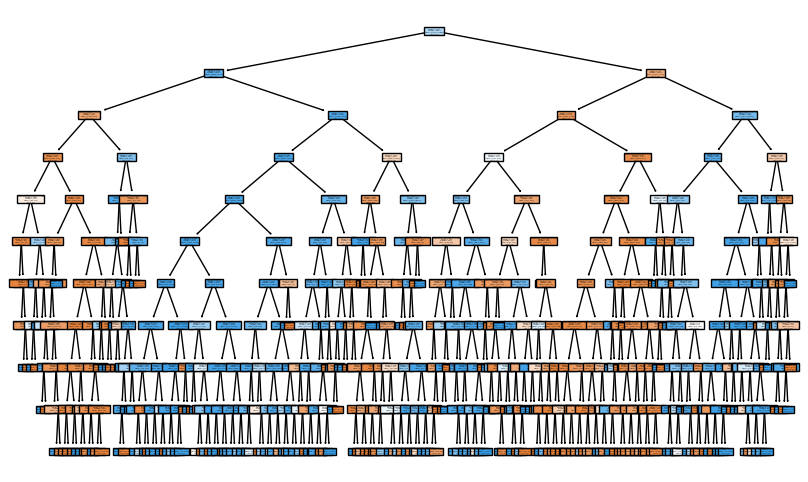

In [4]:
plt.figure(figsize=(10, 6))
plot_tree(clf, feature_names=selected_features, class_names=True, filled=True)
plt.show()

In [5]:
# (A-1b) Trénovanie stromového algoritmu (DecisionTreeClassifier)
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [6]:
# (B-1b) Trénovanie nestromového algoritmu (LogisticRegression)
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

In [7]:
# (C-1b) Vyhodnotenie výsledkov s ID3
id3_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
id3_clf.fit(X_train, y_train)
y_pred_id3 = id3_clf.predict(X_test)

In [8]:
# (E-1b) Vyhodnotenie metrík accuracy, precision a recall
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"{name} Model:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print("-" * 30)

evaluate_model("Decision Tree (Depth 10)", y_test, y_pred_tree)
evaluate_model("Logistic Regression", y_test, y_pred_logreg)
evaluate_model("ID3 (Depth 10)", y_test, y_pred_id3)

Decision Tree (Depth 10) Model:
  Accuracy: 0.9335
  Precision: 0.9335
  Recall: 0.9335
------------------------------
Logistic Regression Model:
  Accuracy: 0.9148
  Precision: 0.9146
  Recall: 0.9148
------------------------------
ID3 (Depth 10) Model:
  Accuracy: 0.9335
  Precision: 0.9335
  Recall: 0.9335
------------------------------


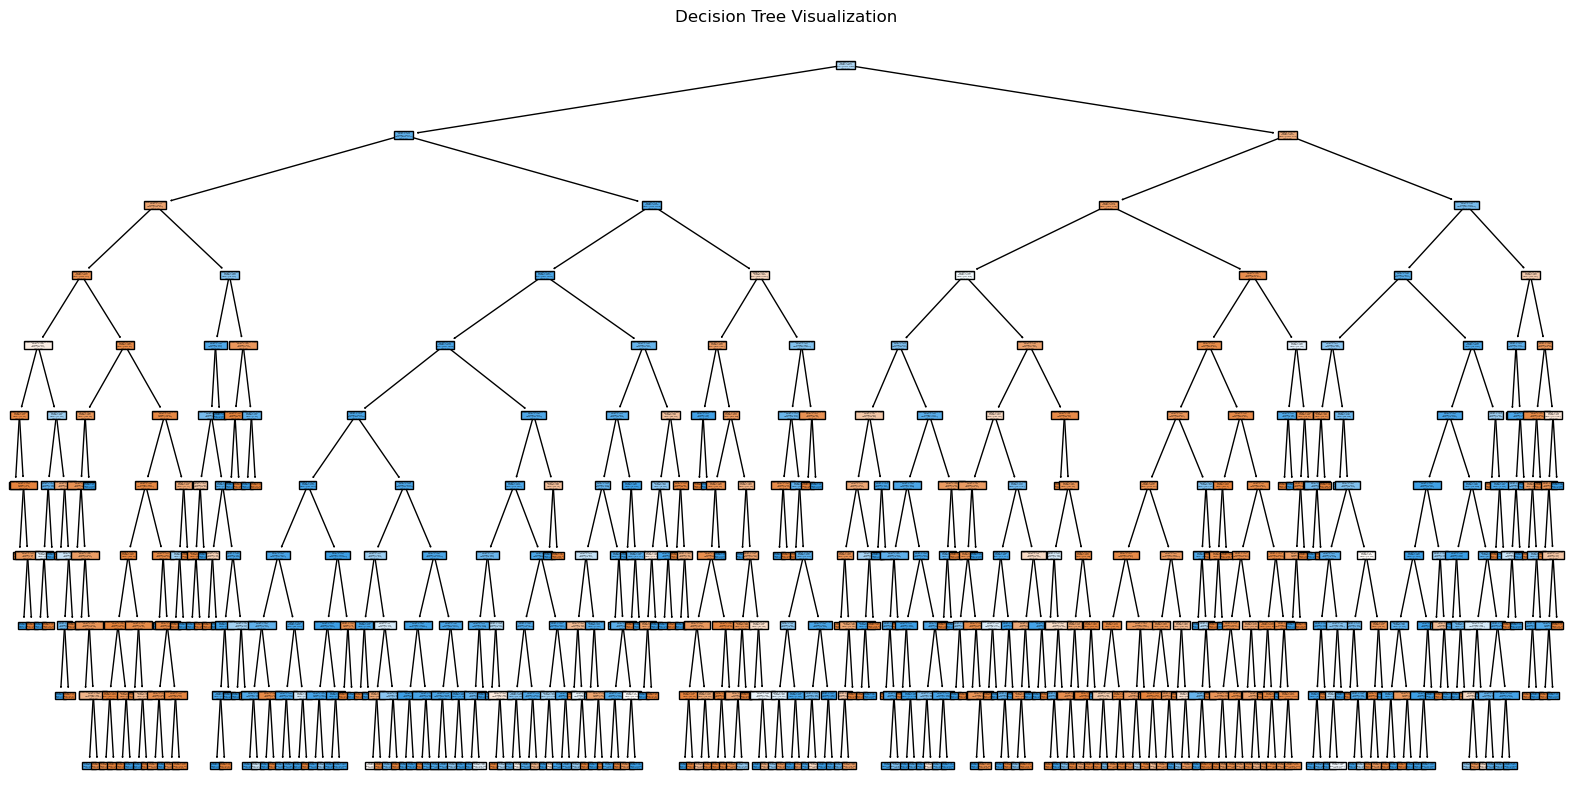

In [9]:
# Vizualizácia rozhodovacieho stromu
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=X_train.columns, class_names=True, filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
# Load and split data
train_df, test_df = train_test_split(df_merged, test_size=0.2, random_state=42)
overlap = set(train_df.index).intersection(set(test_df.index))
print(f"Number of overlapping samples after split: {len(overlap)}")  # Should output 0

# Preprocessing
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['mwra', 'IsRegistrationDefined', 'IsBirthdateDefined']:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

for col in ['ts', 'registration', 'birthdate']:
    if train_df[col].dtype == 'object':
        train_df[col] = pd.to_datetime(train_df[col]).astype(int) / 10**9
        test_df[col] = pd.to_datetime(test_df[col]).astype(int) / 10**9

minmax_columns = ['ts', 'imei', 'birthdate', 'registration', 'job', 'store_name', 'code', 'location', 
                  'residence', 'company', 'ssn', 'name', 'mail', 'username']
other_columns = list(set(numeric_features) - set(minmax_columns))
label_columns = ['store_name', 'code', 'location', 'residence', 'company', 'ssn', 'name', 'mail', 'username', 'job']

label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]]).unique()
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

pipeline_part1 = Pipeline(steps=[
    ('quantile_transform', QuantileTransformer(output_distribution='normal')), 
    ('minmax_scaler', MinMaxScaler())  
])

pipeline_part2 = Pipeline(steps=[
    ('power_transform', PowerTransformer(method='yeo-johnson')), 
    ('standard_scaler', StandardScaler()) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', pipeline_part1, minmax_columns),
        ('scaler', pipeline_part2, other_columns)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = train_df.drop(columns=['mwra'])
y_train = train_df['mwra']
X_test = test_df.drop(columns=['mwra'])
y_test = test_df['mwra']

pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Retrieve feature names from the ColumnTransformer
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Decision Tree Hyperparameter Tuning
print("Optimalizácia hyperparametrov pre Decision Tree...")
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train_transformed, y_train)
best_tree = grid_search_dt.best_estimator_
print(f"Najlepšie parametre Decision Tree: {grid_search_dt.best_params_}")

# Evaluate Tuned Decision Tree
y_pred_dt = best_tree.predict(X_test_transformed)
evaluate_model = lambda name, y_true, y_pred: print(
    f"{name} Model:\n  Accuracy: {accuracy_score(y_true, y_pred):.4f}\n  Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}\n  Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}\n" + "-"*30
)
evaluate_model("Tuned Decision Tree", y_test, y_pred_dt)

# Bagging Classifier
print("Trénovanie kombinovaných modelov...")
bagging_clf = BaggingClassifier(estimator=best_tree, n_estimators=10, random_state=42, n_jobs=-1)
bagging_clf.fit(X_train_transformed, y_train)
y_pred_bagging = bagging_clf.predict(X_test_transformed)
evaluate_model("Bagging Classifier", y_test, y_pred_bagging)

# Random Forest Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

randomized_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=4, 
    cv=3, 
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train_transformed, y_train)
best_rf = randomized_search_rf.best_estimator_

# Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test_transformed)
evaluate_model("Random Forest", y_test, y_pred_rf)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_dt = cross_val_score(best_tree, X_train_transformed, y_train, cv=cv, scoring='accuracy')
cv_scores_bagging = cross_val_score(bagging_clf, X_train_transformed, y_train, cv=cv, scoring='accuracy')
cv_scores_rf = cross_val_score(best_rf, X_train_transformed, y_train, cv=cv, scoring='accuracy')

print("\nKrížová validácia na trénovacej množine...")
print(f"Tuned Decision Tree CV Accuracy: {np.mean(cv_scores_dt):.4f}")
print(f"Bagging Classifier CV Accuracy: {np.mean(cv_scores_bagging):.4f}")
print(f"Random Forest CV Accuracy: {np.mean(cv_scores_rf):.4f}")

# Overfitting Check
print("\nOverenie absencie overfitu...")
print(f"Tuned Decision Tree Overfit: {'No' if best_tree.score(X_train_transformed, y_train) - accuracy_score(y_test, y_pred_dt) <= 0.1 else 'Yes'}")
print(f"Bagging Classifier Overfit: {'No' if bagging_clf.score(X_train_transformed, y_train) - accuracy_score(y_test, y_pred_bagging) <= 0.1 else 'Yes'}")
print(f"Random Forest Overfit: {'No' if best_rf.score(X_train_transformed, y_train) - accuracy_score(y_test, y_pred_rf) <= 0.1 else 'Yes'}")


Number of overlapping samples after split: 0
Optimalizácia hyperparametrov pre Decision Tree...
